2024-09-05 22:56:26,623 - INFO - Data loaded. Shape: (2770, 66)
2024-09-05 22:56:26,625 - INFO - Seasons in data: [2018 2019 2020 2021 2022 2023]
2024-09-05 22:56:26,629 - INFO - Data cleaned. Remaining shape: (2742, 62)


2024-09-05 22:56:26,647 - INFO - Data preprocessing completed. Ready for model training.


New features added.
Columns before encoding: Index(['Season', 'Player', 'Position', 'Age', 'Team', 'TeamID',
       'Years of Service', '3P%', '2P%', 'eFG%', 'FT%', 'PER', 'VORP',
       'Total_Days_Injured', 'Injury_Risk', 'Salary Cap',
       'Salary_Cap_Inflated', 'PPG', 'APG', 'TPG', 'SPG', 'BPG',
       'Availability', 'Efficiency', 'ValueOverReplacement',
       'ExperienceSquared', 'Days_Injured_Percentage', 'WSPG', 'DWSPG',
       'OWSPG', 'PFPG', 'ORPG', 'DRPG'],
      dtype='object')
Encoded data shape: (2742, 68)
Columns after encoding: Index(['Season', 'Age', 'TeamID', 'Years of Service', '3P%', '2P%', 'eFG%',
       'FT%', 'PER', 'VORP', 'Total_Days_Injured', 'Injury_Risk', 'Salary Cap',
       'Salary_Cap_Inflated', 'PPG', 'APG', 'TPG', 'SPG', 'BPG',
       'Availability', 'Efficiency', 'ValueOverReplacement',
       'ExperienceSquared', 'Days_Injured_Percentage', 'WSPG', 'DWSPG',
       'OWSPG', 'PFPG', 'ORPG', 'DRPG', 'Player_Encoded', 'Position_Center',
       'Positio

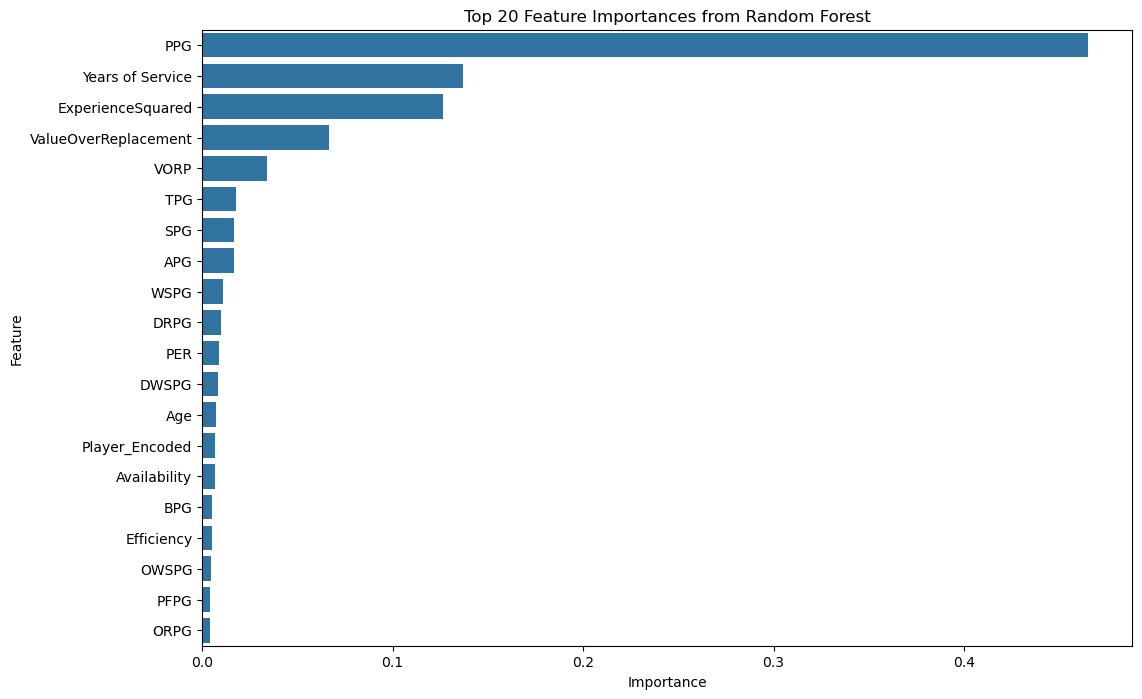


Tree-based feature importances:
                 Feature  Importance
14                   PPG    0.464953
3       Years of Service    0.136672
22     ExperienceSquared    0.126623
21  ValueOverReplacement    0.066478
9                   VORP    0.034262
16                   TPG    0.017983
17                   SPG    0.016807
15                   APG    0.016558
24                  WSPG    0.011061
29                  DRPG    0.009978
8                    PER    0.008923
25                 DWSPG    0.008577
1                    Age    0.007143
30        Player_Encoded    0.006881
19          Availability    0.006701
18                   BPG    0.005315
20            Efficiency    0.004908
26                 OWSPG    0.004869
27                  PFPG    0.004286
28                  ORPG    0.003892
Top 10 features: ['Years of Service', 'PER', 'VORP', 'PPG', 'APG', 'TPG', 'SPG', 'WSPG', 'OWSPG', 'DRPG']

Top features selected using statistical methods: ['Years of Service', 'PER', 'VORP'

In [2]:
# %%writefile ../src/data_loader_preprocessor.py

import pandas as pd
import numpy as np
import logging
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        logger.info(f"Data loaded. Shape: {data.shape}")
        return data
    except Exception as e:
        logger.error(f"Failed to load data from {file_path}: {e}")
        raise

def format_season(data):
    try:
        data['Season'] = data['Season'].apply(lambda x: int(x.split('-')[0]))
        logger.info(f"Seasons in data: {data['Season'].unique()}")
        return data
    except Exception as e:
        logger.error(f"Failed to format season data: {e}")
        raise

def clean_data(data):
    try:
        data_clean = data.copy()
        columns_to_drop = ['Injury_Periods', '2nd Apron', 'Wins', 'Losses']
        data_clean.drop(columns_to_drop, axis=1, errors='ignore', inplace=True)
        
        percentage_cols = ['3P%', '2P%', 'FT%', 'TS%']
        for col in percentage_cols:
            if col in data_clean.columns:
                data_clean[col] = data_clean[col].fillna(data_clean[col].mean())
        
        data_clean = data_clean.dropna()
        logger.info(f"Data cleaned. Remaining shape: {data_clean.shape}")
        return data_clean
    except Exception as e:
        logger.error(f"Failed to clean data: {e}")
        raise

def engineer_features(data):
    # Calculate per-game statistics to normalize performance data
    per_game_cols = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV']
    for col in per_game_cols:
        data[f'{col[0]}PG'] = data[col] / data['GP']
    
    # Derive additional features to capture important aspects of a player's performance
    data['Availability'] = data['GP'] / 82
    data['SalaryPct'] = data['Salary'] / data['Salary_Cap_Inflated']
    data['Efficiency'] = (data['PTS'] + data['TRB'] + data['AST'] + data['STL'] + data['BLK']) / (data['FGA'] + data['FTA'] + data['TOV'] + 1)
    data['ValueOverReplacement'] = data['VORP'] / (data['Salary'] + 1)
    data['ExperienceSquared'] = data['Years of Service'] ** 2
    data['Days_Injured_Percentage'] = data['Total_Days_Injured'] / data['GP']
    data['WSPG'] = data['WS'] / data['GP']
    data['DWSPG'] = data['DWS'] / data['GP']
    data['OWSPG'] = data['OWS'] / data['GP']
    data['PFPG'] = data['PF'] / data['GP']
    data['ORPG'] = data['ORB'] / data['GP']
    data['DRPG'] = data['DRB'] / data['GP']
    
    # Drop columns used in feature creation or deemed less relevant
    columns_to_drop = ['GP', '2PA', 'OBPM', 'BPM', 'DBPM', '2P', 'GS', 'PTS', 'AST', 'TRB', 'STL', 'BLK',
                       'TOV', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB',
                       'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'Luxury Tax', '1st Apron', 'BAE',
                       'Standard /Non-Taxpayer', 'Taxpayer', 'Team Room /Under Cap', 'WS', 'DWS', 'WS/48', 'PF', 'OWS', 'Injured']
    data.drop(columns_to_drop, axis=1, errors='ignore', inplace=True)
    print("New features added.")
    return data

def encode_injury_risk(data):
    # Encode injury risk levels for model training
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    data['Injury_Risk'] = data['Injury_Risk'].map(risk_mapping).fillna(0)  # Default to Low if unknown
    return data, risk_mapping

def encode_categorical(data, columns):
    # Encode categorical columns using one-hot encoding
    encoders = {}
    for col in columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(data[[col]])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=data.index)
        data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)
        encoders[col] = encoder
    return data, encoders


def encode_data(data, encoders=None, player_encoder=None):
    print("Columns before encoding:", data.columns)

    # Encode Injury_Risk
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    data['Injury_Risk'] = data['Injury_Risk'].map(risk_mapping).fillna(0)  # Default to Low if unknown

    # Encode Player column if it's present
    if 'Player' in data.columns:
        if player_encoder is None:
            player_encoder = LabelEncoder()
            data['Player_Encoded'] = player_encoder.fit_transform(data['Player'])
        else:
            data['Player_Encoded'] = player_encoder.transform(data['Player'])
        data.drop('Player', axis=1, inplace=True)  # Drop original Player column after encoding
    
    # Identify initial numeric columns
    initial_numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Encode categorical variables (excluding Season)
    categorical_cols = ['Position', 'Team']
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Updated line
            encoded = encoder.fit_transform(data[[col]])
            encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=data.index)
            data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)
            encoders[col] = encoder
    else:
        for col in categorical_cols:
            encoded = encoders[col].transform(data[[col]])
            encoded_df = pd.DataFrame(encoded, columns=encoders[col].get_feature_names_out([col]), index=data.index)
            data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)

    # Identify final numeric columns (excluding one-hot encoded columns and 'Season')
    numeric_cols = [col for col in initial_numeric_cols if col not in ['Season', 'Injury_Risk', 'Player_Encoded']]

    # Scale numeric features (excluding 'Player_Encoded')
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    print("Encoded data shape:", data.shape)
    print("Columns after encoding:", data.columns)

    return data, risk_mapping, encoders, scaler, numeric_cols, player_encoder



def scale_features(data, numeric_cols):
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data, scaler

def decode_data(encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder):
    decoded_data = encoded_data.copy()
    
    # Decode Injury_Risk
    inv_injury_risk_mapping = {v: k for k, v in injury_risk_mapping.items()}
    decoded_data['Injury_Risk'] = decoded_data['Injury_Risk'].map(inv_injury_risk_mapping)
    
    # Decode Player column
    if 'Player_Encoded' in decoded_data.columns:
        decoded_data['Player'] = player_encoder.inverse_transform(decoded_data['Player_Encoded'])
        decoded_data.drop('Player_Encoded', axis=1, inplace=True)
    
    # Decode categorical variables
    for col, encoder in encoders.items():
        encoded_cols = [c for c in decoded_data.columns if c.startswith(f"{col}_")]
        decoded_col = encoder.inverse_transform(decoded_data[encoded_cols])
        decoded_data[col] = decoded_col.ravel()  # Flatten the 2D array to 1D
        decoded_data.drop(encoded_cols, axis=1, inplace=True)
    
    # Inverse transform scaled features
    decoded_data[numeric_cols] = scaler.inverse_transform(decoded_data[numeric_cols])
    
    return decoded_data

def select_top_features(X, y, k=10):
    # Select top features based on statistical significance
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    top_features = X.columns[selector.get_support()].tolist()
    print(f"Top {k} features:", top_features)
    return top_features

def calculate_tree_feature_importance(X, y):
    # Calculate feature importance using a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances from Random Forest')
    plt.show()
    
    return feature_importances

if __name__ == "__main__":
    try:
        file_path = '../data/processed/nba_player_data_final_inflated.csv'
        data = load_data(file_path)
        data = format_season(data)
        data = clean_data(data)
        data = engineer_features(data)

        # Separate features and target
        X = data.drop(['SalaryPct', 'Salary'], axis=1)
        y = data['SalaryPct']

        # Encode data
        encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder = encode_data(X)
        
        logger.info("Data preprocessing completed. Ready for model training.")
        

        print("\nInjury Risk Mapping:", injury_risk_mapping)
        print("Encoded Injury Risk range:", encoded_data['Injury_Risk'].min(), "-", encoded_data['Injury_Risk'].max())
        print("\nNumeric columns for scaling:", numeric_cols)

        # Calculate feature importance
        feature_importances = calculate_tree_feature_importance(encoded_data, y)
        print("\nTree-based feature importances:")
        print(feature_importances.head(20))

        # Select top features
        top_features = select_top_features(encoded_data, y)
        print("\nTop features selected using statistical methods:", top_features)

        # Decoding example
        print("\nDecoding Example:")
        decoded_data = decode_data(encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder)
        
        print("\nFirst few rows of decoded data:")
        print(decoded_data[['Player', 'Injury_Risk', 'Position', 'Team', 'Season'] + top_features].head())

        print("\nData types after decoding:")
        print(decoded_data.dtypes)

        print("\nData preprocessing completed. Ready for model training.")
        
    except Exception as e:
        logger.critical(f"Critical error in data processing pipeline: {e}")
        raise

In [4]:
# %%writefile ../src/model_trainer.py
import joblib
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np

def inspect_data_types(X):
    print("Data types of features:")
    print(X.dtypes)
    object_columns = X.select_dtypes(include=['object']).columns
    if not object_columns.empty:
        print("Columns with object data types:", object_columns.tolist())
    else:
        print("No columns with object data types.")

def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {-grid_search.best_score_}")
    return grid_search.best_estimator_

def train_and_save_models(X_train, y_train, model_save_path, scaler, feature_names, encoders, player_encoder, numeric_cols):
    # Inspect data types before training
    inspect_data_types(X_train)

    # Initialize models with default parameters
    rf_model = RandomForestRegressor(random_state=42)
    xgb_model = xgb.XGBRegressor(random_state=42, enable_categorical=True)

    # Define parameter grids for grid search
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    # Perform grid search
    best_rf_model = perform_grid_search(rf_model, rf_param_grid, X_train, y_train)
    best_xgb_model = perform_grid_search(xgb_model, xgb_param_grid, X_train, y_train)

    # Train models with best parameters
    best_rf_model.fit(X_train, y_train)
    best_xgb_model.fit(X_train, y_train)

    # Scale the features used for training
    X_train_scaled = scaler.fit_transform(X_train)

    # Save models, scaler, feature names, encoders, and other artifacts
    joblib.dump(best_rf_model, f"{model_save_path}/best_rf_model.pkl")
    joblib.dump(best_xgb_model, f"{model_save_path}/best_xgb_model.pkl")
    joblib.dump(scaler, f"{model_save_path}/scaler.pkl")
    joblib.dump(feature_names, f"{model_save_path}/feature_names.pkl")
    joblib.dump(encoders, f"{model_save_path}/encoders.pkl")
    joblib.dump(injury_risk_mapping, f"{model_save_path}/injury_risk_mapping.pkl")
    joblib.dump(numeric_cols, f"{model_save_path}/numeric_cols.pkl")

    joblib.dump(player_encoder, f"{model_save_path}/player_encoder.pkl")
    print("Models, scaler, feature names, encoders, and other artifacts trained and saved successfully.")

def evaluate_models(X_test, y_test, model_save_path):
    # Load models, scaler, and feature names
    rf_model = joblib.load(f"{model_save_path}/best_rf_model.pkl")
    xgb_model = joblib.load(f"{model_save_path}/best_xgb_model.pkl")

    # Make predictions
    rf_predictions = rf_model.predict(X_test)
    xgb_predictions = xgb_model.predict(X_test)

    # Evaluate models using multiple metrics
    metrics = {'Random Forest': rf_predictions, 'XGBoost': xgb_predictions}

    for model_name, predictions in metrics.items():
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        print(f"\n{model_name} Evaluation:")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R-squared: {r2}")
        
def filter_seasons(data, predict_season):
    """
    Filters the dataset into prior seasons and the target season for prediction.

    Args:
        data (pd.DataFrame): The dataset containing season data.
        predict_season (int): The season that you want to predict.

    Returns:
        tuple: A tuple containing two DataFrames:
            - prior_seasons_data: Data for seasons before the predict_season.
            - target_season_data: Data for the predict_season.
    """
    # Separate data into prior seasons and the target season
    prior_seasons_data = data[data['Season'] < predict_season]
    target_season_data = data[data['Season'] == predict_season]
    
    print(f"Data filtered. Prior seasons shape: {prior_seasons_data.shape}, Target season shape: {target_season_data.shape}")
    
    return target_season_data, prior_seasons_data

# Data preprocessing
def load_and_preprocess_data(file_path, predict_season):
    data = load_data(file_path)
    data = format_season(data)
    _, prior_seasons_data = filter_seasons(data, predict_season)
    prior_seasons_data = clean_data(prior_seasons_data)
    prior_seasons_data = engineer_features(prior_seasons_data)
    return prior_seasons_data

# Feature selection
def select_features(data, target_column, additional_features=[]):
    top_features = ['PPG', 'APG', 'RPG', 'SPG', 'TOPG', 'Years of Service', 'PER', 'VORP', 'WSPG', 'OWSPG']
    
    # Add 'Injury_Risk', 'Position', and 'Team' to ensure they're included for encoding
    top_features += ['Injury_Risk', 'Position', 'Team']
    
    # Add any additional features
    top_features += additional_features
    
    # Ensure all selected features are in the dataset
    available_features = [col for col in top_features if col in data.columns]
    
    print("Available features for modeling:", available_features)  # Debug statement

    X = data[available_features]
    y = data[target_column]
    return X, y

# Main execution
if __name__ == "__main__":
    file_path = '../data/processed/nba_player_data_final_inflated.csv'
    predict_season = 2023
    target_column = 'SalaryPct'

    # Load and preprocess data
    preprocessed_data = load_and_preprocess_data(file_path, predict_season)
    print("Columns after preprocessing:", preprocessed_data.columns)

    # Select features
    X, y = select_features(preprocessed_data, target_column)
    print("Columns after feature selection:", X.columns)

    # Encode data
    encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder = encode_data(X)
    print("Columns after encoding:", encoded_data.columns)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=0.2, random_state=42)

    # Train and evaluate models
    model_save_path = '../data/models'
    train_and_save_models(X_train, y_train, model_save_path, scaler, encoded_data.columns, encoders, injury_risk_mapping, numeric_cols)
    evaluate_models(X_test, y_test, model_save_path)


2024-09-05 22:56:41,723 - INFO - Data loaded. Shape: (2770, 66)
2024-09-05 22:56:41,725 - INFO - Seasons in data: [2018 2019 2020 2021 2022 2023]
2024-09-05 22:56:41,729 - INFO - Data cleaned. Remaining shape: (2274, 62)


Data filtered. Prior seasons shape: (2294, 66), Target season shape: (476, 66)
New features added.
Columns after preprocessing: Index(['Season', 'Player', 'Position', 'Age', 'Team', 'TeamID',
       'Years of Service', '3P%', '2P%', 'eFG%', 'FT%', 'PER', 'VORP',
       'Salary', 'Total_Days_Injured', 'Injury_Risk', 'Salary Cap',
       'Salary_Cap_Inflated', 'PPG', 'APG', 'TPG', 'SPG', 'BPG',
       'Availability', 'SalaryPct', 'Efficiency', 'ValueOverReplacement',
       'ExperienceSquared', 'Days_Injured_Percentage', 'WSPG', 'DWSPG',
       'OWSPG', 'PFPG', 'ORPG', 'DRPG'],
      dtype='object')
Available features for modeling: ['PPG', 'APG', 'SPG', 'Years of Service', 'PER', 'VORP', 'WSPG', 'OWSPG', 'Injury_Risk', 'Position', 'Team']
Columns after feature selection: Index(['PPG', 'APG', 'SPG', 'Years of Service', 'PER', 'VORP', 'WSPG', 'OWSPG',
       'Injury_Risk', 'Position', 'Team'],
      dtype='object')
Columns before encoding: Index(['PPG', 'APG', 'SPG', 'Years of Service', 'P

/tmp/ipykernel_3789/2476059257.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Injury_Risk'] = data['Injury_Risk'].map(risk_mapping).fillna(0)  # Default to Low if unknown


Best parameters for RandomForestRegressor: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best score for RandomForestRegressor: 0.0012834948032834912
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best score for XGBRegressor: 0.0012904983060722786
Models, scaler, feature names, encoders, and other artifacts trained and saved successfully.

Random Forest Evaluation:
MSE: 0.0016220538848449447
RMSE: 0.04027473010269522
MAE: 0.02480031642184796
R-squared: 0.7613369643359506

XGBoost Evaluation:
MSE: 0.0016789013017395082
RMSE: 0.040974398125408845
MAE: 0.024530031791389666
R-squared: 0.7529726447455362


In [13]:
%%writefile ../src/model_predictor.py

import joblib
import pandas as pd

def load_models_and_utils(model_save_path):
    rf_model = joblib.load(f"{model_save_path}/best_rf_model.pkl")
    xgb_model = joblib.load(f"{model_save_path}/best_xgb_model.pkl")
    scaler = joblib.load(f"{model_save_path}/scaler.pkl")
    feature_names = joblib.load(f"{model_save_path}/feature_names.pkl")
    encoders = joblib.load(f"{model_save_path}/encoders.pkl")
    injury_risk_mapping = joblib.load(f"{model_save_path}/injury_risk_mapping.pkl")
    numeric_cols = joblib.load(f"{model_save_path}/numeric_cols.pkl")
    player_encoder = joblib.load(f"{model_save_path}/player_encoder.pkl")
    return rf_model, xgb_model, scaler, feature_names, encoders, injury_risk_mapping, numeric_cols, player_encoder

def predict(data, model_save_path):
    rf_model, xgb_model, scaler, feature_names, encoders, _, _, player_encoder = load_models_and_utils(model_save_path)
    
    print("Original data shape:", data.shape)
    print("Original data columns:", data.columns.tolist())

    # Preserve player names
    player_names = data['Player'] if 'Player' in data.columns else None
    
    # Drop the player column before encoding
    data = data.drop(columns=['Player'], errors='ignore')
    
    # Encode the data using the loaded encoders
    encoded_data, _, _, _, _, _ = encode_data(data, encoders, player_encoder)
    
    print("Encoded data shape:", encoded_data.shape)
    print("Encoded data columns:", encoded_data.columns.tolist())
    
    # Handle missing features: Add missing columns and set them to zero
    for col in feature_names:
        if col not in encoded_data.columns:
            encoded_data[col] = 0

    # Ensure encoded_data only has feature_names columns
    encoded_data = encoded_data[feature_names]
    
    print("Selected features shape:", encoded_data.shape)
    print("Selected features:", encoded_data.columns.tolist())
    print("Expected features:", feature_names)
    
    # Scale the encoded data
    encoded_data_scaled = scaler.transform(encoded_data)
    
    # Make predictions
    rf_predictions = rf_model.predict(encoded_data_scaled)
    xgb_predictions = xgb_model.predict(encoded_data_scaled)
    
    # Create a DataFrame for predictions
    predictions_df = pd.DataFrame({
        'RF_Predictions': rf_predictions,
        'XGB_Predictions': xgb_predictions,
        'Predicted_Salary': (rf_predictions + xgb_predictions) / 2
    })
    
    # Attach player names back to the predictions
    if player_names is not None:
        predictions_df['Player'] = player_names.values

    # Combine the predictions with the original data (excluding player names)
    result = pd.concat([data.reset_index(drop=True), predictions_df], axis=1)

    return result


if __name__ == "__main__":
    file_path = 'data/processed/nba_player_data_final_inflated.csv'
    predict_season = 2023
    data = load_data(file_path)
    data = format_season(data)
    current_season_data, _ = filter_seasons(data, predict_season)
    current_season_data = clean_data(current_season_data)
    current_season_data = engineer_features(current_season_data)
    model_save_path = 'data/models'
    predictions_df = predict(current_season_data, model_save_path)  # Save predictions as predictions_df
    print(predictions_df.head())
    
    # Save predictions_df for later use
    predictions_df.to_csv('data/processed/predictions_df.csv', index=False)


Overwriting ../src/model_predictor.py


In [2]:
%%writefile ../src/app.py

import os
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import plotly.graph_objects as go
from datetime import datetime
from nba_api.stats.static import teams, players

# Import functions from other modules
from data_loader_preprocessor import load_data, format_season, clean_data, engineer_features, encode_data
from model_trainer import train_and_save_models, evaluate_models
from model_predictor import predict

# Importing Shot Chart Analysis functions
from shot_chart.nba_helpers import get_team_abbreviation, categorize_shot, get_all_court_areas
from shot_chart.nba_shots import fetch_shots_data, fetch_defensive_shots_data, fetch_shots_for_multiple_players
from shot_chart.nba_plotting import plot_shot_chart_hexbin
from shot_chart.nba_efficiency import create_mae_table, save_mae_table, load_mae_table, get_seasons_range, calculate_compatibility_between_players
from shot_chart.shot_chart_main import run_scenario, preload_mae_tables, create_and_save_mae_table_specific, create_and_save_mae_table_all

# Import functions from the small example app
from advanced_metrics import plot_career_clusters, plot_injury_risk_vs_salary, plot_availability_vs_salary, plot_vorp_vs_salary, table_metric_salary, display_top_10_salary_per_metric, cluster_players_specialized, display_top_10_salary_per_metric_with_ws

# Import New and improved Trade functions
from trade_impact_section_st_app import trade_impact_simulator_app

@st.cache_data
def get_teams_list():
    """Get the list of NBA teams."""
    return [team['full_name'] for team in teams.get_teams()]

@st.cache_data
def get_players_list():
    """Get the list of NBA players."""
    return [player['full_name'] for player in players.get_players()]

@st.cache_data
def load_team_data():
    nba_teams = teams.get_teams()
    team_df = pd.DataFrame(nba_teams)
    return team_df[['id', 'full_name', 'abbreviation']]

@st.cache_data
def load_player_data(start_year, end_year):
    player_data = pd.DataFrame()
    for year in range(start_year, end_year + 1):
        data = fetch_season_data_by_year(year)
        if data is not None:
            player_data = pd.concat([player_data, data], ignore_index=True)
    return player_data

def identify_overpaid_underpaid(predictions_df):
    # Adjust Predicted_Salary calculation
    predictions_df['Predicted_Salary'] = predictions_df['Predicted_Salary'] * predictions_df['Salary_Cap_Inflated']
    
    predictions_df['Salary_Difference'] = predictions_df['Salary'] - predictions_df['Predicted_Salary']
    predictions_df['Overpaid'] = predictions_df['Salary_Difference'] > 0
    predictions_df['Underpaid'] = predictions_df['Salary_Difference'] < 0
    
    overpaid = predictions_df[predictions_df['Overpaid']].sort_values('Salary_Difference', ascending=False)
    underpaid = predictions_df[predictions_df['Underpaid']].sort_values('Salary_Difference')
    
    return overpaid.head(10), underpaid.head(10)

# Utility functions
def load_processed_data(file_path):
    data = load_data(file_path)
    data = format_season(data)
    data = clean_data(data)
    data = engineer_features(data)
    return data

def filter_data_by_season(data, season):
    return data[data['Season'] == season]

# Data visualization functions
def plot_feature_distribution(data, feature):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data[feature], kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    return fig

def plot_correlation_heatmap(data):
    numeric_data = data.select_dtypes(include=[np.number])
    corr = numeric_data.corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, annot=False, cmap='coolwarm', ax=ax)
    ax.set_title('Correlation Heatmap')
    return fig

# Model metrics function
def display_model_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    st.subheader("Model Performance Metrics")
    col1, col2, col3, col4 = st.columns(4)
    col1.metric("Mean Squared Error", f"{mse:.4f}")
    col2.metric("Root Mean Squared Error", f"{rmse:.4f}")
    col3.metric("Mean Absolute Error", f"{mae:.4f}")
    col4.metric("R-squared", f"{r2:.4f}")

def display_overpaid_underpaid(predictions_df):
    st.subheader("Top 10 Overpaid and Underpaid Players")

    # Add filters
    col1, col2 = st.columns(2)
    with col1:
        team_filter = st.multiselect("Filter by Team", options=sorted(predictions_df['Team'].unique()))
    with col2:
        position_filter = st.multiselect("Filter by Position", options=sorted(predictions_df['Position'].unique()))

    # Apply filters
    filtered_df = predictions_df
    if team_filter:
        filtered_df = filtered_df[filtered_df['Team'].isin(team_filter)]
    if position_filter:
        filtered_df = filtered_df[filtered_df['Position'].isin(position_filter)]

    # Identify overpaid and underpaid players
    overpaid, underpaid = identify_overpaid_underpaid(filtered_df)

    col1, col2 = st.columns(2)
    with col1:
        st.subheader("Top 10 Overpaid Players")
        st.dataframe(overpaid[['Player', 'Team', 'Position', 'Salary', 'Predicted_Salary', 'Salary_Difference']])

    with col2:
        st.subheader("Top 10 Underpaid Players")
        st.dataframe(underpaid[['Player', 'Team', 'Position', 'Salary', 'Predicted_Salary', 'Salary_Difference']])





# Shot Chart Analysis function
def shot_chart_analysis():
    st.header("Shot Chart Analysis")

    # Add guidelines and purpose explanation at the top
    st.markdown("""
    ### Welcome to the NBA Shot Analysis App!
    
    This app allows you to analyze the offensive and defensive efficiency of NBA teams and players. 
    You can compare players or teams to identify the most efficient spots on the court, 
    analyze player compatibility based on shot area efficiency, and much more.
    
    **Options and Guidelines:**
    - **Analysis Type**: Choose between offensive, defensive, or both types of analysis.
    - **Team or Player**: Analyze a team or an individual player.
    - **Court Areas**: Select specific court areas or analyze all areas.
    - **Comparison**: Compare multiple players to see how their offensive efficiencies align or differ.
    """)

    analysis_type = st.selectbox("Select analysis type", options=["offensive", "defensive", "both"])

    entity_type = st.selectbox("Analyze a Team or Player?", options=["team", "player"])

    if entity_type == "team":
        st.markdown("_**Team option is able to analyze both offense and defense by looking into the defense by shot detail from other teams' shot charts against the Opposing Team.**_")
        entity_name = st.selectbox("Select a Team", options=get_teams_list())
    else:
        st.markdown("_**Player Option is only able to look at offense.**_")
        player_names = st.multiselect("Select Players to Analyze", options=get_players_list())

    season = st.selectbox("Select the season", options=["2023-24", "2022-23", "2021-22", "2020-21"])

    opponent_type = st.selectbox("Compare against all teams or a specific team?", options=["all", "specific"])

    opponent_name = None
    if opponent_type == "specific":
        opponent_name = st.selectbox("Select an Opponent Team", options=get_teams_list())

    court_areas = st.selectbox("Select court areas to analyze", options=["all", "specific"], index=0)

    if court_areas == "specific":
        court_areas = st.multiselect("Select specific court areas", options=get_all_court_areas())
    else:
        court_areas = "all"

    debug_mode = st.checkbox("Enable Debug Mode", value=False)

    if st.button("Run Analysis"):
        if entity_type == "player" and (not player_names or len(player_names) < 1):
            st.error("Please select at least one player.")
        else:
            if entity_type == "player":
                if len(player_names) == 1:
                    # Single player analysis
                    run_scenario(
                        entity_name=player_names[0],
                        entity_type=entity_type,
                        season=season,
                        opponent_name=opponent_name,
                        analysis_type=analysis_type,
                        compare_players=False,
                        player_names=None,
                        court_areas=court_areas
                    )
                else:
                    # Multiple players comparison
                    player_shots = fetch_shots_for_multiple_players(player_names, season, court_areas, opponent_name, debug=debug_mode)

                    for player, shots in player_shots.items():
                        st.pyplot(plot_shot_chart_hexbin(shots['shots'], f'{player} Shot Chart', opponent=opponent_name if opponent_name else "all teams"))
                        st.write(f"Efficiency for {player}:")
                        st.write(shots['efficiency'])

                    compatibility_df = calculate_compatibility_between_players(player_shots)
                    st.write("Player Shooting Area Compatibility:")
                    st.write(compatibility_df)
            else:
                # Team analysis
                run_scenario(
                    entity_name=entity_name,
                    entity_type=entity_type,
                    season=season,
                    opponent_name=opponent_name,
                    analysis_type=analysis_type,
                    compare_players=False,
                    court_areas=court_areas
                )

    # Add explanation for shot chart MAE analysis
    with st.expander("Understanding MAE in Player Analysis with context from their Shooting"):
        st.markdown("""
        **MAE** is a metric that measures the average magnitude of errors between predicted values and actual values, without considering their direction.
        
        In our context, MAE is used to measure the difference between the shooting efficiencies of two players across various areas on the court.
        
        **Steps to Analyze MAE:**
        1. **Define Common Areas**: The court is divided into areas like "Left Corner 3", "Top of Key", "Paint", etc.
        2. **Calculate Individual Efficiencies**: Fetch shot data for each player and calculate their shooting efficiency in these areas.
        3. **Identify Common Areas**: When comparing players, identify the areas where both players have taken shots.
        4. **Calculate MAE**: Compute the absolute difference between efficiencies in each common area and average them.
        5. **Interpret Compatibility**:
            - **High MAE**: Indicates players excel in different areas (more compatible).
            - **Low MAE**: Indicates similar efficiencies in the same areas (less compatible).
        
        **Use this metric to assess player compatibility based on where they excel on the court!**
        """)

    with st.expander("Understanding MAE in Team (offensive or defensive) in comparison to other Teams"):
        st.markdown("""
        **MAE** is a metric that measures the average magnitude of errors between predicted values and actual values, without considering their direction.
        
        In the context of team analysis, MAE is used to measure the difference between the shooting efficiencies of one team's offense and the defensive efficiencies of other teams.
        
        **Steps to Analyze MAE for Team Comparison:**
        1. **Calculate Offensive Efficiency**: Fetch shot data for the team of interest and calculate their shooting efficiency across various areas on the court.
        2. **Calculate Defensive Efficiency of Opponents**: For each opponent team, calculate their defensive efficiency by analyzing how well they defend these same areas on the court.
        3. **Calculate MAE**: Compute the MAE between the offensive efficiency of the team of interest and the defensive efficiencies of each opponent team across the defined court areas.
        4. **Interpret the Results**:
            - **Low MAE**: Indicates that the opponent team is effective at defending the areas where the team of interest typically excels. This suggests that the opponent is a "bad fit" for the team of interest, as they defend well against their strengths.
            - **High MAE**: Indicates that the opponent team struggles to defend the areas where the team of interest typically excels. This suggests that the opponent is a "good fit" for the team of interest, as their defense is less effective against the team's offensive strengths.
        
        **Use this analysis to identify which teams are tough matchups (bad fits) versus easier matchups (good fits) based on how well they can defend your team's key offensive areas!**
        """)


# Advanced Metrics Analysis Function
def advanced_metrics_analysis():
    st.header("NBA Advanced Metrics and Salary Analysis")
    
    # Load the data
    data = pd.read_csv('data/processed/nba_player_data_final_inflated.csv')
    
    # Add a dropdown to select the season
    seasons = sorted(data['Season'].unique(), reverse=True)
    selected_season = st.selectbox("Select a Season", seasons)
    
    # Filter the data by the selected season
    data_season = data[data['Season'] == selected_season]
    
    # Cluster players based on the filtered data
    data_season = cluster_players_specialized(data_season, n_clusters=7)
    
    st.header("Plots")
    
    # Dropdown to select the plot
    plot_choice = st.selectbox("Select a plot to view:", 
                               ["Career Clusters: Age vs Salary", 
                                "Injury Risk vs Salary", 
                                "Availability vs Salary", 
                                "VORP vs Salary"])
    
    if plot_choice == "Career Clusters: Age vs Salary":
        fig = plot_career_clusters(data_season)
        st.pyplot(fig)
    elif plot_choice == "Injury Risk vs Salary":
        fig = plot_injury_risk_vs_salary(data_season)
        st.pyplot(fig)
    elif plot_choice == "Availability vs Salary":
        fig = plot_availability_vs_salary(data_season)
        st.pyplot(fig)
    elif plot_choice == "VORP vs Salary":
        fig = plot_vorp_vs_salary(data_season)
        st.pyplot(fig)
    
    st.header("Top 10 Salary per Metric Tables")
    
    # Calculate metrics table
    metric_salary_table = table_metric_salary(data_season)
    
    # Dropdown to select the metric table
    metric_choice = st.selectbox("Select a metric to view top 10:", 
                                 ["Salary_per_WS", 
                                  "Salary_per_VORP", 
                                  "Salary_per_OWS", 
                                  "Salary_per_DWS"])
    
    # Display the selected top 10 table with WS included
    top_10_table = display_top_10_salary_per_metric_with_ws(metric_salary_table, metric_choice)
    st.write(f"Top 10 {metric_choice}:")
    st.dataframe(top_10_table)

# Main Streamlit app
def main():
    st.set_page_config(page_title="NBA Salary Prediction, Trade Analysis, and Shot Chart Analysis", layout="wide")
    st.title("NBA Salary Prediction, Trade Analysis, and Shot Chart Analysis")

    # Sidebar navigation
    st.sidebar.title("Navigation")
    page = st.sidebar.radio(
        "Go to",
        [
            "Introduction",
            "Data Analysis",
            "Model Results",
            "Salary Evaluation",
            "Shot Chart Analysis",
            "Advanced Metrics Analysis",
            "Trade Impact Simulator"
        ]
    )

    # Load base data
    print(os.getcwd())
    data = load_processed_data('data/processed/nba_player_data_final_inflated.csv')

    # Load existing predictions for 2023
    initial_predictions_df = pd.read_csv('data/processed/predictions_df.csv')

    # Season selection
    seasons = sorted(data['Season'].unique(), reverse=True)
    selected_season = st.selectbox("Select Season", seasons)

    # Load models at the beginning of main()
    model_save_path = 'data/models'
    rf_model = joblib.load(f"{model_save_path}/best_rf_model.pkl")
    xgb_model = joblib.load(f"{model_save_path}/best_xgb_model.pkl")

    # Use initial predictions if 2023 is selected, otherwise retrain
    if selected_season == 2023:
        predictions_df = initial_predictions_df
    else:
        # Train model and make predictions
        train_data = data[data['Season'] < selected_season]
        test_data = data[data['Season'] == selected_season]

        # Prepare the data for training
        X_train = train_data.drop(['SalaryPct', 'Salary', 'Player'], axis=1)
        y_train = train_data['SalaryPct']

        # Encode the training data
        X_train_encoded, _, encoders, scaler, numeric_cols, player_encoder = encode_data(X_train)

        # Train and save models
        train_and_save_models(X_train_encoded, y_train, model_save_path, scaler, X_train_encoded.columns, encoders, player_encoder, numeric_cols)

        # Make predictions on the test data
        predictions_df = predict(test_data, model_save_path)


    if page == "Introduction":
        st.title("Enhanced NBA Player Salary Analysis")
        st.write("Welcome to the NBA Salary Analysis and Prediction App! This project aims to provide comprehensive insights into NBA player salaries, advanced metrics, and future salary predictions based on historical data. Here's a detailed breakdown of the steps involved in creating this app:")

        st.subheader("Data Collection")
        
        st.write("### Salary Data")
        st.write("- **Sources**:")
        st.write("  - [Basketball Reference Salary Cap History](https://www.basketball-reference.com/contracts/salary-cap-history.html)")
        st.write("- **Description**: Data on the NBA salary cap from various seasons, along with maximum salary details for players based on years of service.")

        st.write("### Add Injury Data (source will need to be updated**):")
        st.write("- **Source**: [Kaggle NBA Injury Stats 1951-2023](https://www.kaggle.com/datasets/loganlauton/nba-injury-stats-1951-2023/data)")
        st.write("- **Description**: This dataset provides detailed statistics on NBA injuries from 1951 to 2023, allowing for analysis of player availability and its impact on performance and salaries.")

        st.write("### Advanced Metrics")
        st.write("- **Source**: [Basketball Reference](https://www.basketball-reference.com)")
        st.write("- **Description**: Advanced player metrics such as Player Efficiency Rating (PER), True Shooting Percentage (TS%), and Value Over Replacement Player (VORP) were scraped using BeautifulSoup.")

        st.write("### Player Salaries and Team Data")
        st.write("- **Source**: [Hoopshype](https://hoopshype.com)")
        st.write("- **Description**: Player salary data was scraped for multiple seasons, with detailed information on individual player earnings and team salaries.")

        st.subheader("Data Processing")

        st.write("### Inflation Adjustment")
        st.write("- **Source**: [Adjusting for Inflation in Python](https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-data-with-python-9d69a8dcbc27)")
        st.write("- **Description**: Adjusted historical salary data for inflation to provide a consistent basis for comparison.")

        st.write("### Data Aggregation")
        st.write("- Steps:")
        st.write("  1. Loaded salary data and combined it with team standings and advanced metrics.")
        st.write("  2. Merged multiple data sources to create a comprehensive dataset containing player performance, salaries, and advanced metrics.")

        st.subheader("Model Training and Prediction")

        st.write("### Data Preprocessing")
        st.write("- Implemented functions to handle missing values, perform feature engineering, and calculate key metrics such as points per game (PPG), assists per game (APG), and salary growth.")

        st.write("### Model Selection")
        st.write("- Utilized various machine learning models including Random Forest, Gradient Boosting, Ridge Regression, and others to predict future player salaries.")
        st.write("- Employed grid search for hyperparameter tuning and selected the best-performing models based on evaluation metrics like Mean Squared Error (MSE) and R² score.")

        st.write("### Feature Importance and Clustering")
        st.write("- Analyzed feature importance to understand the key factors influencing player salaries.")
        st.write("- Clustered players into categories based on career trajectories, providing insights into player development and value.")

        st.subheader("App Development")

        st.write("### Streamlit App")
        st.write("- Built an interactive app using Streamlit to visualize data, perform exploratory data analysis, and make salary predictions.")
        st.write("- **Features**:")
        st.write("  - **Data Overview**: Display raw and processed data.")
        st.write("  - **Exploratory Data Analysis**: Visualize salary distributions, age vs. salary, and other key metrics.")
        st.write("  - **Advanced Analytics**: Analyze VORP to salary ratio, career trajectory clusters, and other advanced metrics.")
        st.write("  - **Salary Predictions**: Predict future salaries and compare actual vs. predicted values.")
        st.write("  - **Player Comparisons**: Compare selected players based on predicted salaries and performance metrics.")
        st.write("  - **Model Evaluation**: Evaluate different models and display their performance metrics and feature importance.")

        st.write("### Data Files")
        st.write("- Stored processed data and model files in a structured format to facilitate easy loading and analysis within the app.")

        st.subheader("Improvements:")
        
        st.subheader("Conclusion")

        st.write("This app provides a robust platform for analyzing NBA player salaries, understanding the factors influencing earnings, and predicting future salaries based on historical data and advanced metrics. Explore the app to gain insights into player performance, salary trends, and much more.")


    elif page == "Data Analysis":
        st.header("Data Analysis")

        # Filter data by selected season
        season_data = filter_data_by_season(data, selected_season)

        # Display basic statistics
        st.subheader("Basic Statistics")
        st.write(season_data.describe())

        # Feature distribution
        st.subheader("Feature Distribution")
        feature = st.selectbox("Select Feature", season_data.columns)
        fig = plot_feature_distribution(season_data, feature)
        st.pyplot(fig)

        # Correlation heatmap
        st.subheader("Correlation Heatmap")
        fig = plot_correlation_heatmap(season_data)
        st.pyplot(fig)

        # Data handling explanation
        st.subheader("Data Handling")
        st.write("""
        We preprocessed the data to ensure it's suitable for our models:
        1. Cleaned missing values and outliers
        2. Engineered new features like PPG, APG, etc.
        3. Encoded categorical variables (Position, Team, Injury Risk)
        4. Scaled numerical features
        """)

    elif page == "Model Results":
        st.header("Model Results")

        # Model selection
        model_choice = st.selectbox("Select Model", ["Random Forest", "XGBoost"])

        if model_choice == "Random Forest":
            model = rf_model
            y_pred = predictions_df['RF_Predictions']
        else:
            model = xgb_model
            y_pred = predictions_df['XGB_Predictions']

        # Display model metrics
        display_model_metrics(predictions_df['SalaryPct'], y_pred)

        # Feature importance
        st.subheader("Feature Importance")
        feature_importance = pd.DataFrame({
            'feature': model.feature_names_in_,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        print("Features used in the model:", model.feature_names_in_)  # Debug statement
        print("Feature importance data:", feature_importance.head())  # Debug statement
        # Filter out categorical variables (e.g., Position_ and Team_ columns)
        filtered_feature_importance = feature_importance[
            ~feature_importance['feature'].str.startswith('Team_') &
            ~feature_importance['feature'].str.startswith('Position_') &
            ~feature_importance['feature'].str.startswith('Injury_Risk')
        ]

        # Before plotting feature importance
        print("Filtered features for plotting:", filtered_feature_importance['feature'].tolist())  # Debug statement
        st.bar_chart(filtered_feature_importance.set_index('feature'))


        # Model explanation
        st.subheader("Model Explanation")
        st.write(f"""
        The {model_choice} model was trained on historical NBA player data to predict salary percentages.
        We used the following techniques to improve model performance:
        1. Feature engineering to create relevant statistics
        2. Proper encoding of categorical variables
        3. Scaling of numerical features
        4. Hyperparameter tuning using GridSearchCV
        """)
        
    elif page == "Salary Evaluation":
        st.header("Salary Evaluation")
        display_overpaid_underpaid(predictions_df)
        st.write("""
        Using the Predicted Salary and Salary based on that season's stats, we can identify 
        overpaid and underpaid players. We find the difference to uncover potential value opportunities for different teams.
        """)
        

    elif page == "Shot Chart Analysis":
        shot_chart_analysis()

    elif page == "Advanced Metrics Analysis":
        advanced_metrics_analysis()

    elif page == "Trade Impact Simulator":
        st.header("Trade Impact Simulator")
        
        # Assume selected_season is in YYYY format (e.g., 2023)
        trade_impact_simulator_app(selected_season)
        

if __name__ == "__main__":
    main()


Overwriting ../src/app.py
